In [1]:
"""Number game"""
import math

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from IPython.display import display, HTML

In [51]:
# Common
class Hypothesis(object):
    def __init__(self, name, generator_fn, number_range=(1, 500)):
        self.name = name
        self.numbers = self._generate_numbers(generator_fn, 
                                              number_range)
    
    @property
    def size(self):
        return len(self.numbers)
        
    def _generate_numbers(self, generator_fn, number_range):
        rmin, rmax = number_range
        return list(filter(generator_fn, range(rmin, rmax + 1)))
    
    def __repr__(self):
        if self.size > 3:
            trimmed_list = "[{}, ...]".format(str(self.numbers[:3])[1:-1])
        else:
            trimmed_list = "{}".format(self.numbers)
            
        return "H({}; {}; {})".format(self.name, 
                                      trimmed_list,
                                      self.size)


def is_power(x, y):
    while x % y == 0:
        x = x / y
    return x == 1    


def is_prime(n):
    if n % 2 == 0 and n > 2: 
        return False
    for i in range(3, int(math.sqrt(n)) + 1, 2):
        if n % i == 0:
            return False
    return True


def generate_hypothesis_space():
    hs = [
        Hypothesis('Even numbers', lambda x: x % 2 == 0),
        Hypothesis('Odd numbers', lambda x: x % 2 == 1),
    ] 

    # Arithmetic sequences
    for i in range(3, 251):
        hs.append(
            Hypothesis('Arithmetic seq %d' % i, lambda x: x % i == 0)
        )

    # Powers of numbers
   

    for i in range(2, int(math.sqrt(500)) + 1):
        hs.append(
            Hypothesis('Power seq %d' % i, lambda x: is_power(x, i))
        )
    
    return hs


def contains(parent_list, child_list):
    return set(child_list).issubset(set(parent_list))


def calculate_lk(hypothesis, data):
    if not contains(hypothesis.numbers, data):
        return 0
    
    return math.pow(1.0 / hypothesis.size, len(data))


def calculate_posteriori(priori, likelihood, all_likelihoods):
    return (priori * likelihood) / sum(all_likelihoods) 


def get_best_hypothesis(data_containers, val_fn):
    best_h = None
    best_h_val = -1
    
    for dc in data_containers:
        current_val = val_fn(dc)
        if current_val > best_h_val:
            best_h_val = current_val
            best_h = dc.hypothesis
            
    return best_h, best_h_val


def get_hypothesis_using_map(data_containers):
    return get_best_hypothesis(data_containers, lambda dc: dc.likelihood * dc.prior)#math.log(dc.likelihood) + math.log(dc.prior))


def get_hypothesis_using_mle(data_containers):
    return get_best_hypothesis(data_containers, lambda dc: dc.likelihood)
        

In [4]:
# Common plotting and "GUI"
def plot_barplot(data, attr_name, ax):
    sns.barplot(y=[dc.hypothesis.name for dc in data], 
                x=[getattr(dc, attr_name) for dc in data],
                orient='h',
                ax=ax)
    
    
def likelihood_containers_to_dataframe(lkcs):
    df = pd.DataFrame(columns=['Hypothesis', 'Likelihood'])
    
    for lkc in lkcs:
        df = df.append({'Hypothesis': lkc.hypothesis, 
                        'Likelihood': lkc.likelihood},
                       ignore_index=True)
    
    return df
    
    
def print_sorted_likelihood(data_containers):
    df = likelihood_containers_to_dataframe(data_containers)
    df = df.sort_values(by=['Likelihood'], ascending=False)
    display(HTML(df.to_html()))
    
    
def posterior_containers_to_dataframe(poscs):
    df = pd.DataFrame(columns=['Hypothesis', 'Prior', 
                               'Likelihood', 'Posterior'])
    
    for pos in poscs:
        df = df.append({'Hypothesis': pos.hypothesis,
                        'Prior': pos.prior,
                        'Likelihood': pos.likelihood,
                        'Posterior': pos.posterior},
                       ignore_index=True)
    
    return df


def print_sorted_posterior(data_containers):
    df = posterior_containers_to_dataframe(data_containers)
    df = df.sort_values(by=['Posterior'], ascending=False)
    display(HTML(df.to_html()))
    
    
def plot_priori_likelihood_posteriori(data_containers):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
    
    plot_barplot(data_containers, 'prior', ax1)
    plot_barplot(data_containers, 'likelihood', ax2)
    plot_barplot(data_containers, 'posterior', ax3)

,Hypothesis,Likelihood
11,"H(Power seq 12; [1, 12, 144]; 3)",0.333333
12,"H(Power seq 13; [1, 13, 169]; 3)",0.333333
20,"H(Power seq 21; [1, 21, 441]; 3)",0.333333
19,"H(Power seq 20; [1, 20, 400]; 3)",0.333333
18,"H(Power seq 19; [1, 19, 361]; 3)",0.333333
17,"H(Power seq 18; [1, 18, 324]; 3)",0.333333
16,"H(Power seq 17; [1, 17, 289]; 3)",0.333333
15,"H(Power seq 16; [1, 16, 256]; 3)",0.333333
14,"H(Power seq 15; [1, 15, 225]; 3)",0.333333
13,"H(Power seq 14; [1, 14, 196]; 3)",0.333333


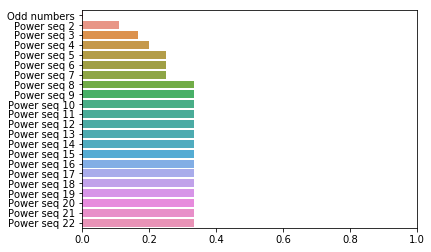

In [5]:
# 1. Only Likelihood
class LikelihoodContainer(object):
    def __init__(self, hypothesis, data):
        self.hypothesis = hypothesis
        self.likelihood = calculate_lk(hypothesis, data)
    
    def __repr__(self):
        return "LK({}; {})".format(self.hypothesis, self.likelihood)
    
    
def make_number_game_with_likelihood_only(hypothesis_space, data):    
    likelihoods = []

    for h in hypothesis_space:
        likelihoods.append(LikelihoodContainer(h, data))
        
    non_zero_likelihoods = list(filter(lambda lkc: lkc.likelihood != 0, likelihoods))
    return non_zero_likelihoods
    
    
def run_number_game_with_likelihood_only():        
    data_containers = make_number_game_with_likelihood_only(
        hypothesis_space=generate_hypothesis_space(), 
        data=[1]
    )
    
    print_sorted_likelihood(data_containers)
        
    fig, ax = plt.subplots(1, 1)
    plot_barplot(data_containers, 'likelihood', ax)
    plt.xlim((0, 1))

run_number_game_with_likelihood_only()

,Hypothesis,Prior,Likelihood,Posterior
2,"H(Power seq 2; [1, 2, 4, ...]; 9)",0.004,0.012346,0.003974
0,"H(Even numbers; [2, 4, 6, ...]; 250)",0.215,0.000016,0.000277
1,"H(Arithmetic seq 4; [4, 8, 12, ...]; 125)",0.002,0.000064,0.000010


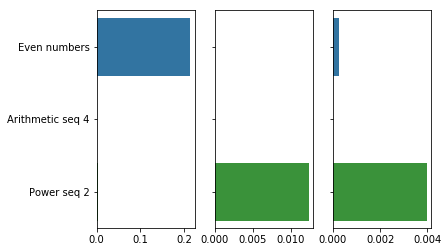

In [6]:
# Only Posterior
class PosteriorContainer(object):
    def __init__(self, hypothesis, prior, data):
        self.hypothesis = hypothesis
        self.prior = prior
        self.likelihood = calculate_lk(hypothesis, data)
        self.posterior = 0
    
    def __repr__(self):
        return "POS({}; {}; {}, {})".format(self.hypothesis, 
                                            self.prior,
                                            self.likelihood,
                                            self.posterior)
    
def get_prior(hypothesis):
    priors = {
        'Even': 0.215,
        'Odd': 0.205,
        'Arithmetic': 0.002,
        'Power': 0.004
    }
    
    for key, val in priors.items():
        if hypothesis.name.startswith(key):
            return val
        
    raise ValueError('Should not happen!')
    
    
def make_number_game_with_posterior_only(hypothesis_space, get_prior_fn, data):    
    all_likelihoods = []
    posteriors = []

    for h in hypothesis_space:
        pos = PosteriorContainer(h, get_prior_fn(h), data)
        all_likelihoods.append(pos.likelihood)
        posteriors.append(pos)
        
    for pos in posteriors:
        pos.posterior = calculate_posteriori(pos.prior, 
                                             pos.likelihood, 
                                             all_likelihoods)
    
    non_zero_posteriors = list(filter(lambda pos: pos.posterior != 0, posteriors))
    return non_zero_posteriors
    
       
def run_number_game_with_posterior_only():
    data_containers = make_number_game_with_posterior_only(
        hypothesis_space=generate_hypothesis_space(),
        get_prior_fn=get_prior,
        data=[4, 8]
    )
    
    print_sorted_posterior(data_containers)
    plot_priori_likelihood_posteriori(data_containers)

run_number_game_with_posterior_only()

,Hypothesis,Likelihood
2,"H(Power seq 2; [1, 2, 4, ...]; 9)",0.012346
1,"H(Arithmetic seq 4; [4, 8, 12, ...]; 125)",0.000064
0,"H(Even numbers; [2, 4, 6, ...]; 250)",0.000016


,Hypothesis,Prior,Likelihood,Posterior
2,"H(Power seq 2; [1, 2, 4, ...]; 9)",0.004,0.012346,0.003974
0,"H(Even numbers; [2, 4, 6, ...]; 250)",0.215,0.000016,0.000277
1,"H(Arithmetic seq 4; [4, 8, 12, ...]; 125)",0.002,0.000064,0.000010


For data [4, 8] MAP chose hypothesis: H(Power seq 2; [1, 2, 4, ...]; 9)


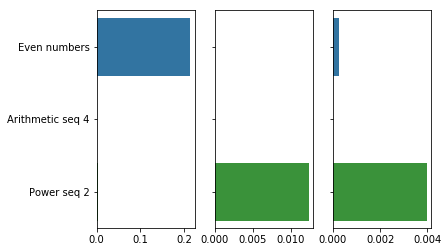

In [25]:
# 3. Number game
def make_number_game(data):    
    data_containers = make_number_game_with_posterior_only(
        hypothesis_space=generate_hypothesis_space(),
        get_prior_fn=get_prior,
        data=data
    )
    
    print_sorted_likelihood(data_containers)
    print_sorted_posterior(data_containers)
    
    plot_priori_likelihood_posteriori(data_containers)
     
    return get_hypothesis_using_map(data_containers)
    
    
def run_number_game():
    data = [4, 8]
    chosen_hypothesis, _ = make_number_game(data)
    print('For data %s MAP chose hypothesis: %s' % (data, chosen_hypothesis))
    
run_number_game()

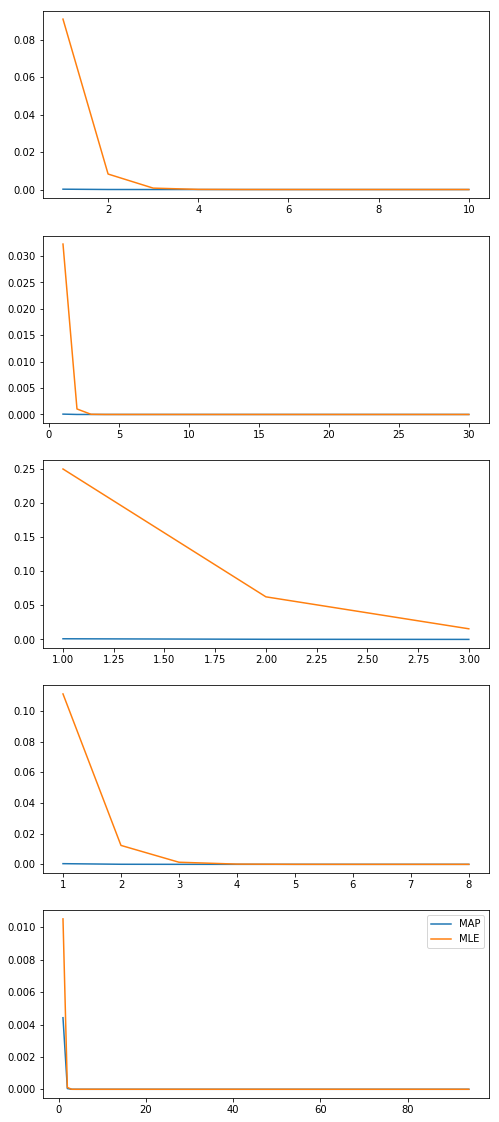

In [55]:
# 4. MAP to MLE convergence check
def get_prior_for_check(hypothesis):
    priors = {
        'Prime': 0.42,
        'Arithmetic': 0.002,
        'Power': 0.004
    }

    for key, val in priors.items():
        if hypothesis.name.startswith(key):
            return val

    raise ValueError('Should not happen!')

    
def run_check():
    hypothesis = [
        Hypothesis('Arithmetic seq 45', lambda x: x % 45 == 0),
        Hypothesis('Arithmetic seq 16', lambda x: x % 16 == 0),
        Hypothesis('Power seq 7', lambda x: is_power(x, 7)),
        Hypothesis('Power seq 2', lambda x: is_power(x, 2)),
        Hypothesis('Prime numbers', lambda x: x > 1 and is_prime(x)),
    ]

    fig, axs = plt.subplots(5, 1, figsize=(8, 20))
    
    for idx, h in enumerate(hypothesis):
        xs = []
        maps = []
        mles = []
        
        for x in range(1, len(h.numbers)):
            dcs = make_number_game_with_posterior_only(
                hypothesis_space=[h],
                get_prior_fn=get_prior_for_check,
                data=h.numbers[:x]
            )
            
            _, map_ = get_hypothesis_using_map(dcs)
            _, mle_ = get_hypothesis_using_mle(dcs)
            
            xs.append(x)
            maps.append(map_)
            mles.append(mle_)
        
        axs[idx].plot(xs, maps, label='MAP')
        axs[idx].plot(xs, mles, label='MLE')
    
    plt.legend()
    plt.show()
    
    
run_check()